<h1><center> Predict Future Sales - Exploring Data </center></h1>

****

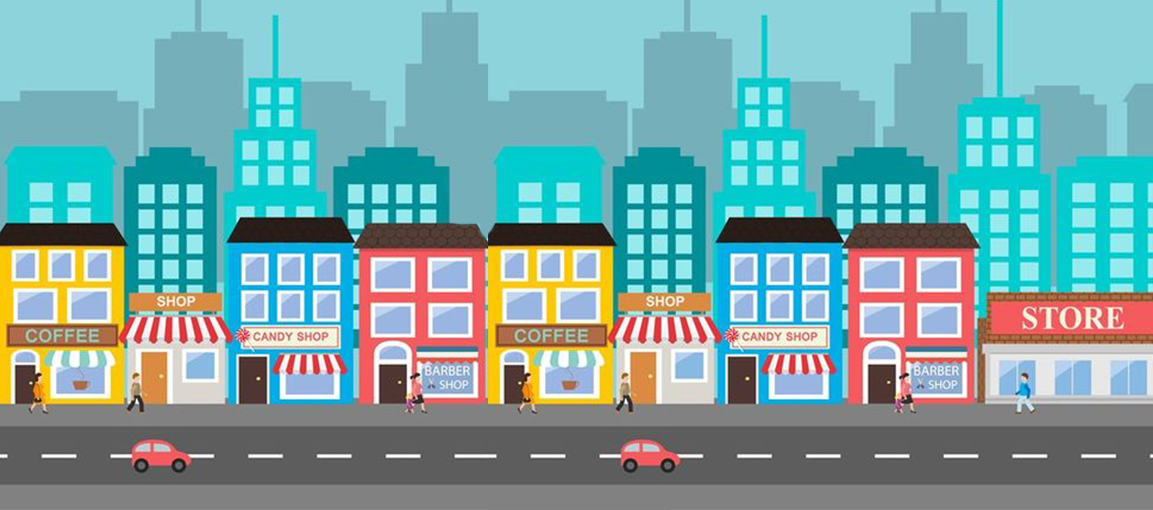

<h1> Introduction </h1>

****

In this competition, we have to predict the total sales for each product and store in the next month. To solved this problem, we are given daily historical sales data from several stores in 33 months ( January 2013 to October 2015 ). In this notebook, I will explore existing data to help in prediction models.

## File descriptions

> * sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
> * test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
> * sample_submission.csv - a sample submission file in the correct format.
> * items.csv - supplemental information about the items/products.
> * item_categories.csv  - supplemental information about the items categories.
> * shops.csv- supplemental information about the shops.

## Data fields

> * ID - an Id that represents a (Shop, Item) tuple within the test set
> * shop_id - unique identifier of a shop
> * item_id - unique identifier of a product
> * item_category_id - unique identifier of item category
> * item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
> * item_price - current price of an item
> * date - date in format dd/mm/yyyy
> * date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
> * item_name - name of item
> * shop_name - name of shop
> * item_category_name - name of item category

## Import necessary libraries

In [ ]:
!pip install calplot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import calplot

import seaborn as sns


import plotly.offline as ply
import plotly.graph_objs as go
from plotly.tools import make_subplots
import colorlover as cl

chosen_colors=cl.scales['5']['qual']['Paired']
ply.init_notebook_mode(connected=True)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Load Data

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
item_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')

sample_subs = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [ ]:
print(f'there are {sales_train.shape[0]} rows and {sales_train.shape[1]} columns')
sales_train

In [ ]:
print(f'there are {item_cat.shape[0]} rows and {item_cat.shape[1]} columns')
item_cat.head(5)

In [ ]:
print(f'there are {items.shape[0]} rows and {items.shape[1]} columns')
items.head(5)

In [ ]:
print(f'there are {shops.shape[0]} rows and {shops.shape[1]} columns')
shops.head(5)

Check missing value from data

In [ ]:
print('---' * 10)
print('sales_train check\n')
print(sales_train.isna().sum())
print('---' * 10)
print('item_cat check\n')
print(item_cat.isna().sum())
print('---' * 10)
print('item check\n')
print(items.isna().sum())
print('---' * 10)
print('shops check\n')
print(shops.isna().sum())

Based on this data, it seems like there is no data missing, let's examine it deeper

In [ ]:
sales_train.describe()

there is an outliner in the item price and item_cnt_day columns. The minus value on item_cnt_day can be from the returned item ([notebook](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/50591)). let's check it out

In [ ]:
# outliner
sales_train[sales_train.item_cnt_day > 900]

In [ ]:
sales_train[sales_train.item_price > 100000]

In [ ]:
sales_train[sales_train.item_price < 0]

In [ ]:
sales_train[sales_train.item_cnt_day < 0]

In [ ]:
## Drop item_price and item_cnt_day too high
sales_train = sales_train[sales_train.item_price<100000] # drop 1
sales_train = sales_train[sales_train.item_cnt_day<1000] # drop 2

## Drop negative price 
sales_train = sales_train[sales_train.item_price > 0].reset_index(drop=True) # drop 1

## The item has been returned 
sales_train.loc[sales_train.item_cnt_day < 0, 'item_cnt_day'] = 0

<h2>Information</h2>
 
based on this [notebook](http://www.kaggle.com/tristanleclercq/predict-future-sales-full-solution-xgboost) it can be concluded

> *  Shop 0-57, 1-58, 10-11, are the same, but different time periods
> *  Shop 40 is likely to be an antenna of shop 39, so we aggregate their sales together
> *  There is data leaked in test data ( shop 40 )

so, i will change and drop some shop name to solved that problem

In [ ]:
shops.drop(0,axis=0,inplace=True)
shops.drop(1,axis=0,inplace=True)
shops.drop(11,axis=0,inplace=True)
shops.drop(40,axis=0,inplace=True)

sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10
sales_train.loc[sales_train.shop_id == 40, 'shop_id'] = 39

merge data into one dataframe and extract feature from date colomn

In [ ]:
# Merge data
items = pd.merge(items, item_cat, on = 'item_category_id')
sales_train = pd.merge(sales_train, shops, on='shop_id')
sales_train = pd.merge(sales_train, items, on = 'item_id')

In [ ]:
# extract feature
sales_train['total_sales'] = sales_train.item_price * sales_train.item_cnt_day

sales_train['date'] = pd.to_datetime(sales_train.date)
sales_train['Month'] = sales_train['date'].dt.month
sales_train['Year'] = sales_train['date'].dt.year
sales_train['day_of_week'] = sales_train['date'].dt.day_name()

In [ ]:
# Dtype of dataset
sales_train.info()

<h1><center>  DATA EXPLORATION </center></h1>

****

<h1><center> TIME </center></h1>

****

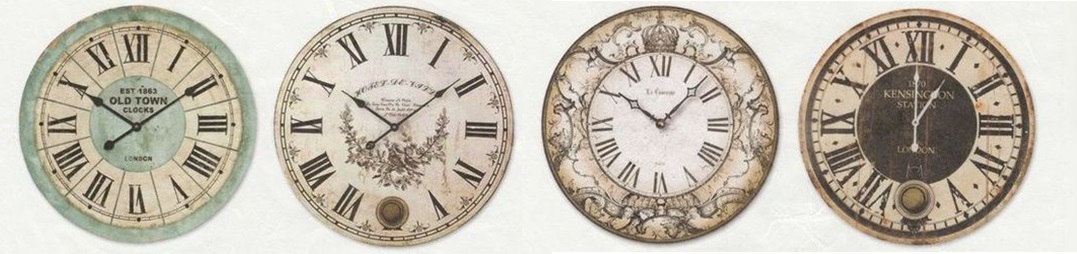

we are given daily historical sales data from several stores in 33 months ( January 2013 to October 2015 )

### Monthly Sales and Revenue

In [ ]:
temp_df = sales_train.groupby('date_block_num')[['item_cnt_day','total_sales']].sum().reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df.date_block_num, y=temp_df.item_cnt_day,
                    mode='lines',
                    line= dict(color='royalblue', width=2)))

fig.update_layout(title='Monthly Sales',
                   xaxis_title='Month',
                   yaxis_title='Total item sold')

fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df.date_block_num, y=temp_df.total_sales,
                    mode='lines',
                    line= dict(color='royalblue', width=2)))

fig.update_layout(title='Monthly Revenue',
                   xaxis_title='Month',
                   yaxis_title='?')

fig.show()

### Anual Sales
> which years are the most selling ?

In [ ]:
years_item_cnt = sales_train.groupby('Year')['item_cnt_day'].sum().reset_index()

trace1 = go.Bar(
    x=years_item_cnt.Year,
    y=years_item_cnt.item_cnt_day,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]

    )
)

data=[trace1]

layout = go.Layout(
    title='Annual Sales',
    xaxis_type='category',
    xaxis=dict(
        title='Years'
    ),
    yaxis=dict(
        title='Total Item sold'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

### Daily Sales
> which days is the most selling ?

In [ ]:
temp_df = sales_train.groupby('day_of_week').sum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df.index.values, y=temp_df.item_cnt_day,
                    mode='lines',
                    line= dict(color='royalblue', width=2)))

fig.update_layout(title='Daily Sales',
                   xaxis_title='Days',
                   yaxis_title='Total item sold')

fig.show()

In [ ]:
calender = sales_train[['date','item_cnt_day']]
calender.set_index('date', inplace = True)
calender  = calender.resample("D")["item_cnt_day"].sum()

calplot.calplot(calender,
               figsize=(20,12),
               suptitle= 'Total sales')

<h1><center> Store </center></h1>

****

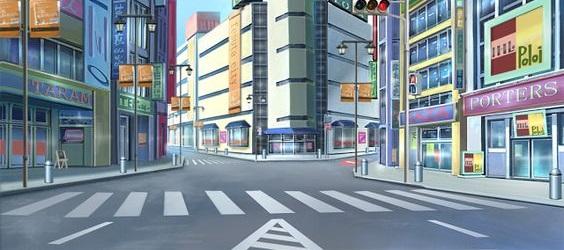

In [ ]:
temp = len(sales_train.shop_name.unique())
print(f'there are {temp} store in dataset')

### which shop is the highest and lowest revenue ?

In [ ]:
shop_revenue = sales_train.groupby(['shop_name'])['total_sales'].sum().sort_values(ascending=False).reset_index()
shop_revenue_H = shop_revenue.head(7)
shop_revenue_L = shop_revenue.tail(7)

trace1 = go.Bar(
    x=shop_revenue_H.shop_name,
    y=shop_revenue_H.total_sales,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]
    )
)

data=[trace1]

layout = go.Layout(
    title='The highest shop revenue',
    xaxis_type='category',
    yaxis=dict(
        title='Total revenue'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

trace1 = go.Bar(
    x=shop_revenue_L.shop_name,
    y=shop_revenue_L.total_sales,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]
    )
)

data=[trace1]

layout = go.Layout(
    title='The lowest shop revenue',
    xaxis_type='category',
    yaxis=dict(
        title='Total revenue'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

### which shop is the most popular and lowest ?

In [ ]:
shop_sell = sales_train.groupby(['shop_name'])['item_cnt_day'].sum().sort_values(ascending=False).reset_index()
shop_sell_H = shop_sell.head(7)
shop_sell_L = shop_sell.tail(7)

trace1 = go.Bar(
    x=shop_sell_H.shop_name,
    y=shop_sell_H.item_cnt_day,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]
    )
)

data=[trace1]

layout = go.Layout(
    title='The highest-selling shop',
    xaxis_type='category',
    yaxis=dict(
        title='Total item sold'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

trace1 = go.Bar(
    x=shop_sell_L.shop_name,
    y=shop_sell_L.item_cnt_day,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]
    )
)

data=[trace1]

layout = go.Layout(
    title='The lowest-selling shop',
    xaxis_type='category',
    yaxis=dict(
        title='Total item sold'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

<h1><center> Items </center></h1>

****

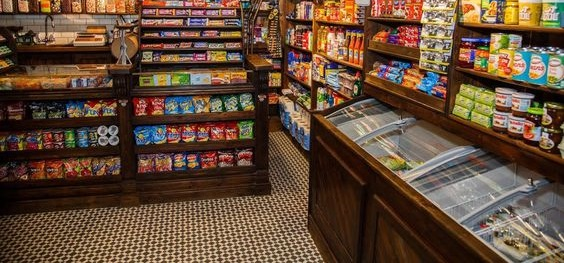

In [ ]:
temp = len(sales_train.item_name.unique())
temp1 = len(sales_train.item_category_name.unique())
print(f'there are {temp} unique item and {temp1} unique item category in store')

### which item category is the most popular and the worst?

In [ ]:
items_cat_cnt = sales_train.groupby(['item_category_name'])['item_cnt_day'].sum().sort_values(ascending=False).reset_index()
items_cat_cnt_H = items_cat_cnt.head(7)
items_cat_cnt_L = items_cat_cnt.tail(7)

trace1 = go.Bar(
    x=items_cat_cnt_H.item_category_name,
    y=items_cat_cnt_H.item_cnt_day,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]
    )
)

data=[trace1]

layout = go.Layout(
    title='The Most popular item category',
    xaxis_type='category',
    yaxis=dict(
        title='Total item sold'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

trace1 = go.Bar(
    x=items_cat_cnt_L.item_category_name,
    y=items_cat_cnt_L.item_cnt_day,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]
    )
)

data=[trace1]

layout = go.Layout(
    title='The Worst item Category',
    xaxis_type='category',
    yaxis=dict(
        title='Total item sold'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

### which item name is the most popular and the worst?

In [ ]:
item_name_sales = sales_train.groupby(['item_name'])['item_cnt_day'].sum().sort_values(ascending=False).reset_index()
item_name_sales_H = item_name_sales.head(7)
item_name_sales_L = item_name_sales.tail(7)

trace1 = go.Bar(
    x=item_name_sales_H.item_name,
    y=item_name_sales_H.item_cnt_day,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]
    )
)

data=[trace1]

layout = go.Layout(
    title='The most popular item',
    xaxis_type='category',
    yaxis=dict(
        title='Total item sold'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

trace1 = go.Bar(
    x=item_name_sales_L.item_name,
    y=item_name_sales_L.item_cnt_day,
    textposition='outside',
    marker=dict(
        color=chosen_colors[0]
    )
)

data=[trace1]

layout = go.Layout(
    title='The worst selling items',
    xaxis_type='category',
    yaxis=dict(
        title='Total item sold'
    )
)

figure = go.Figure(data=data, layout=layout)

figure.show()

<h1><center>Thank you for reading my notebook, upvote if you like this notebook :)</center></h1>

****
